In [78]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Oct 25 22:07:47 2018

@author: jamesgolding
"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

base_path = "/Users/jamesgolding/git/python/Kaggle/Fruits";

IMG_HEIGHT = 32
IMG_WIDTH = 32
IMG_CHANNELS = 3

train_path = base_path + "/Training";
test_path = base_path + "/Test";

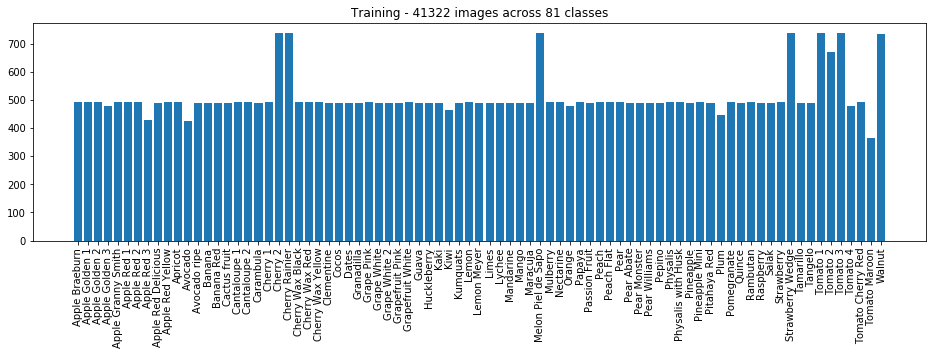

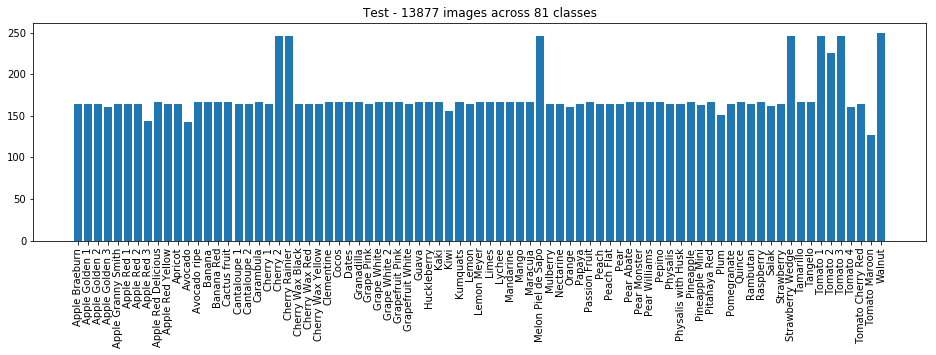

In [70]:
# create list of image paths and categories
def getfruits(path, fruit_names):
    i = -1;
    img_label = [];
    img_paths = [];
    fruit_dict = {};
    if len(fruit_names) == 0:
        fruit_names = os.listdir(path);
    for fruit_name in fruit_names:
        if os.path.isdir(path + "/" + fruit_name):
            i += 1;
            img_names = os.listdir(path + "/" + fruit_name);
            fruit_dict[fruit_name] = len(img_names);
            for img_name in img_names:
                if img_name.endswith(".jpg"):
                    img_label.append(i)
                    img_paths.append(path + "/" + fruit_name + "/" + img_name);
    return img_paths, img_label, fruit_dict;

train_paths, train_labels, train_summary = getfruits(train_path, "");
fruit_names = train_summary.keys();
test_paths, test_labels, test_summary = getfruits(test_path, fruit_names);

n_train = len(train_paths)
n_test = len(test_paths)
n_classes = len(train_summary.keys())

plt.figure(figsize=(16,4));
plt.bar(train_summary.keys(), train_summary.values());
plt.xticks(rotation='vertical');
plt.title("Training" + " - " + str(n_train) + " images across " + str(n_classes) + " classes");
plt.figure(figsize=(16,4));
plt.bar(test_summary.keys(), test_summary.values());
plt.xticks(rotation='vertical');
plt.title("Test" + " - " + str(n_test) + " images across " + str(n_classes) + " classes");

In [66]:
# write tf record
def writetfrecord(filenames, labels, target):
    writer = tf.python_io.TFRecordWriter(target);
    for i in range(len(filenames)):
        filename = filenames[i];
        label = labels[i];
        # read in image and resize it
        img = Image.open(filename)
        img = img.resize((IMG_HEIGHT, IMG_WIDTH))
        img_raw = img.tobytes()
        # write example protocol
        example = tf.train.Example(
            features = tf.train.Features(
                feature = {
                    "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
                    "image_raw": tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw]))
                    }
                )
            )
        writer.write(example.SerializeToString())
    writer.close()

# read tf record
def readtfrecord(tfrecord_filename, n_samples, n_batch):
    feature_key = {
        "label": tf.FixedLenFeature([],tf.int64),
        "image_raw": tf.FixedLenFeature([],tf.string)
        }
    features = tf.parse_single_example(tfrecord_filename, feature_key)
    img = tf.decode_raw(features["image_raw"], tf.uint8)
    img = tf.reshape(img, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    img = tf.cast(img, tf.float32) * (1./255) - 0.5
    label = tf.cast(features["label"], tf.int32)
    # cast to tf and shuffle
    images,labels = tf.train.shuffle_batch([img, label],
                                           batch_size=n_batch,
                                           capacity=n_samples + n_batch,
                                           min_after_dequeue=n_samples)
    return images, labels

In [65]:
# write records
writetfrecord(train_paths, train_labels, "TFRecordTraining.tfrecords");
writetfrecord(test_paths, test_labels, "TFRecordTest.tfrecords");

In [71]:
n_batch = 100
# tf graph input
X = tf.placeholder(tf.float32, [None, n_train])
Y = tf.placeholder(tf.float32, [None, n_classes])
drpt = tf.placeholder(tf.float32)
# make weights and bias variables and dropout fixed
states = {
    # 5x5 conv, 3 inputs, 16 outpus
    'wc1': tf.get_variable('wc1',[3,3,3,32], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    # 5x5 conv, 16 input, 32 outpus
    'wc2': tf.get_variable('wc2',[3,3,32,64], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc3': tf.get_variable('wc3',[3,3,64,128], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    # 5x5 conv, 64 inputs, 128 outputs
    'wc4': tf.get_variable('wc4',[3,3,128,256], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    # 5x5 conv, 128 inputs, 256 outputs
    'wc5': tf.get_variable('wc5',[3,3,256,512], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    # fully connected, 7*7*128 inputs, 2048 outputs
    'wd1': tf.get_variable('wd1',[512,2048], initializer=tf.contrib.layers.xavier_initializer()),
    # 32 inputs, 26 outputs (class prediction)
    'wout': tf.get_variable('fc1',[2048, n_classes], initializer=tf.contrib.layers.xavier_initializer()),
    'bc1': tf.Variable(tf.zeros([32])),
    'bc2': tf.Variable(tf.zeros([64])),
    'bc3': tf.Variable(tf.zeros([128])),
    'bc4': tf.Variable(tf.zeros([256])),
    'bc5': tf.Variable(tf.zeros([512])),
    'bd1': tf.Variable(tf.zeros([2048])),
    'bout': tf.Variable(tf.zeros([n_classes])),
    'dc2': tf.constant(0.98),
    'dc3': tf.constant(0.95),
    'dc4': tf.constant(0.9),
    'dc5': tf.constant(0.9)
}

In [79]:
# define convolution layer
def convmaxpool(x, weight, bias, kC=1, kP=2):
    # conv2d wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, weight, strides=[1,kC,kC,1], padding='SAME')
    x = tf.nn.bias_add(x, bias)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, ksize=[1,kP,kP,1], strides=[1,kP,kP,1], padding='SAME')
    return x

# define network
def cnn(X, weights, drpt):
    X = tf.reshape(X, shape=[-1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    # convolution layer and max pooling
    conv1 = convmaxpool(X, weights['wc1'], weights['bc1'], kP=2)
    # convolution layer and max pooling
    conv2 = convmaxpool(conv1, weights['wc2'], weights['bc2'], kP=2)
    conv2 = tf.nn.dropout(conv2, weights['dc2'])
    # convolution layer and max pooling
    conv3 = convmaxpool(conv2, weights['wc3'], weights['bc3'], kP=2)
    conv3 = tf.nn.dropout(conv3, weights['dc3'])
    # convolution layer and max pooling
    conv4 = convmaxpool(conv3, weights['wc4'], weights['bc4'], kP=2)
    conv4 = tf.nn.dropout(conv4, weights['dc4'])
    # convolution layer and max pooling
    conv5 = convmaxpool(conv4, weights['wc5'], weights['bc5'], kP=2)
    conv5 = tf.nn.dropout(conv5, weights['dc5'])
    # fully connected layer
    fc1 = tf.reshape(conv5, shape=[-1,weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), weights['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, drpt)
    # output, class prediction
    out = tf.add(tf.matmul(fc1, weights['wout']), weights['bout'])
    return out

# saver
saver = tf.train.Saver();

# construct model
logits = cnn(X, states, drpt)
pred = tf.nn.softmax(logits)
# define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss=loss_op)
# evaluate model
is_correct = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

In [ ]:
def trainModel(images, labels):
    n_samples_remaining = n_train
    acc_sum = 0
    while n_samples_tested < n_train:
        with tf.Graph().as_default():
            batch_x, y_id = sess.run([images, labels])
            batch_x = np.reshape(batch_x, [n_batch, IMG_HEIGHT*IMG_WIDTH*IMG_CHANNELS])
            batch_y = np.zeros(shape=[n_batch, n_classes])
            batch_y[np.arange(n_batch), np.array(y_id)] = 1

            # optimise cnn
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, drpt: dropout})
            saver.save(sess, "tf_fruits_model")
            n_samples_tested += n_batch

def testModel(images, labels):
    # calulate the test data sets accuracy
    n_samples_remaining = n_test
    acc_sum = 0
    while n_samples_tested < n_test:
        with tf.Graph().as_default():
            # test batch
            test_x, y_id = sess.run([images, labels])
            test_x = np.reshape(test_x, [n_test, n_input])
            test_y = np.zeros(shape=[n_test, n_classes])
            test_y[np.arange(n_test), np.array(y_id)] = 1
            
            acc, pred_test = sess.run([accuracy, pred], feed_dict={X: test_x, Y: test_y, drpt: 1})
            acc_sum += acc * n_batch
            n_samples_tested += n_batch
    print("Testing accuracy = ", acc_sum / n_samples_tested)

def updateLearningRate(acc, lr_start):
    learning_rate_new = lr_start - acc * lr_start * 0.9
    return learning_rate_new

saver = tf.train.Saver()

# initialization
init = tf.global_variables_initializer()

with tf.Session() as sess:
    # run the initializer
    sess.run(init)
    # create coord
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    # train the model
    train_images, train_labels = readtfrecord("TFRecordTraining.tfrecords", n_train, n_batch)
    trainModel(train_images, train_labels)
    
    # create coord
    coord2 = tf.train.Coordinator()
    threads2 = tf.train.start_queue_runners(sess=sess, coord=coord2)
    # test the model
    test_images, test_labels = readtfrecord("TFRecordTest.tfrecords", n_test, n_batch)
    testModel(test_images, test_labels)

    # close coord
    coord.request_stop()
    coord.join(threads)
    coord2.request_stop()
    coord2.join(threads2)
    sess.close()